In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, roc_auc_score
import ast 
import seaborn as sns  
import numpy as np
import joblib
import pandas as pd
import pickle



### Data used:

In [15]:
# pre-processed version of original data
original_data_test = pd.read_csv('data/twitter_data/cleaned_tweet_test.csv')

# new dataset
new_data_test = pd.read_csv('data/twitter_data/new_tweet_data_clean.csv')

In [16]:
y_test_original = original_data_test['label']
y_test_new = new_data_test['label']

# This notebook contains all results 

## Result for the baseline model

In [17]:
# load baseline model 
LR_model = joblib.load('saved_models/LR_model.pkl')
# load predictions
LR_pred = joblib.load('saved_models/LR_predictions.pkl')
LR_pred_new = joblib.load('saved_models/LR_predictions_new.pkl')

c:\Users\tore_\anaconda3\envs\deepproject\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tore_\anaconda3\envs\deepproject\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tore_\anaconda3\envs\deepproject\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.2.0. This might 

In [18]:
print("AUC score (original): ", roc_auc_score(y_test_original, LR_pred))
print("Accuracy (original): ", accuracy_score(y_test_original, LR_pred))

print("AUC score (new): ", roc_auc_score(y_test_new, LR_pred_new))
print("Accuracy (new): ", accuracy_score(y_test_new, LR_pred_new))

AUC score (original):  0.8058879445314246
Accuracy (original):  0.805607476635514
AUC score (new):  0.7697676232064878
Accuracy (new):  0.8585807750377453


## Results for the LSTM model

In [19]:
num_epochs = 50
# load models
LSTM_pred = joblib.load('saved_models/test_y_pred_original.pkl')
# round predictions
LSTM_pred = np.round(LSTM_pred)
LSTM_pred_new = joblib.load('saved_models/test_y_pred_new.pkl')
# round predictions
LSTM_pred_new = np.round(LSTM_pred_new)

In [20]:
print("AUC score (original): ", roc_auc_score(y_test_original, LSTM_pred))
print("Accuracy (original): ", accuracy_score(y_test_original, LSTM_pred))

print("AUC score (original): ", roc_auc_score(y_test_new, LSTM_pred_new))
print("Accuracy (new): ", accuracy_score(y_test_new, LSTM_pred_new))

AUC score (original):  0.48966487735778724
Accuracy (original):  0.48909657320872274
AUC score (original):  0.5257825496464961
Accuracy (new):  0.33870156014091596


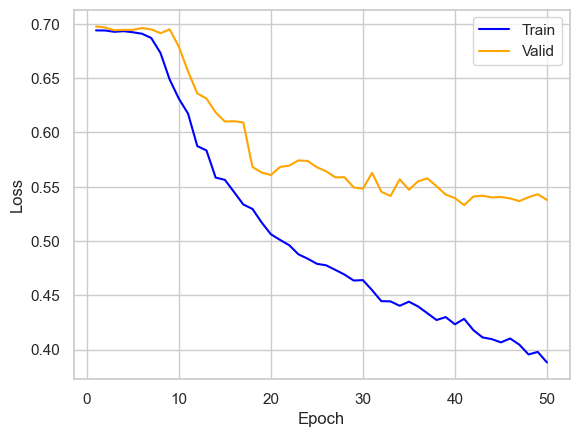

In [21]:
# %%
# load train and valdiation loss
train_loss_list = joblib.load('saved_models/train_loss_original.pkl')
valid_loss_list = joblib.load('saved_models/valid_loss_new.pkl')
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1,num_epochs+1), y=train_loss_list, color='blue', label='Train');
sns.lineplot(x=np.arange(1, num_epochs + 1), y=valid_loss_list, color='orange', label='Valid');
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.show()
#plt.savefig("50epochs_cleaned.png")

# Roc curve
fpr, tpr, threshold = roc_curve(y_test_new, LSTM_pred_new)

# print(fpr,tpr)

# plt.subplots(1, figsize=(10,10))
# plt.title('ROC LSTM')
# plt.plot(fpr, tpr)
# plt.plot([0, 1], ls="--")
# plt.plot([0, 0], [1, 0] , c=".7")
# plt.plot([1, 1] , c=".7")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()
#plt.savefig("50-epochs-roc-cleaned")


## Results for the BERT model

In [37]:
# Load earlier prediction for balanced dataset and unbalanced dataset
predictions_b = np.load('data/PredictedTestData/PredictionTestData_b.npy')
labels_b      = np.load('data/PredictedTestData/Labels_b.npy')
predictions_ub = np.load('data/PredictedTestData/PredictionTestData_ub.npy')
labels_ub      = np.load('data/PredictedTestData/Labels_ub.npy')


In [38]:
# Get accuracy and examples
#accuarcy
acc_unb = np.sum(np.argmax(predictions_unb,axis=-1)==labels_unb)/len(predictions_unb)
acc_b   = np.sum(np.argmax(predictions_b,axis=-1)==labels_b)/len(predictions_b)
print(acc_unb,acc_b)
#examples
print(testset_unblanced['Tweet'][:2], testset_unblanced['Tweet'][175],testset_unblanced['Tweet'][45])

0.8135495078170237 0.7982062780269058
['Fuck you bitch my i want everybody on my page to get on this fool right now RT @cjriley78: @LilBtheGreat dumb ass nigger', '@Leexavier @brunagih e a toca do bulling haha'] RT @lennyfinnegan2: @YesYoureSexist it looks like somebody made this pointless account to get thrills out of telling complete strangers the… my sneaky ass juss dip set outta class early af #idgaf


0.866545357427858 0.7745871526481252


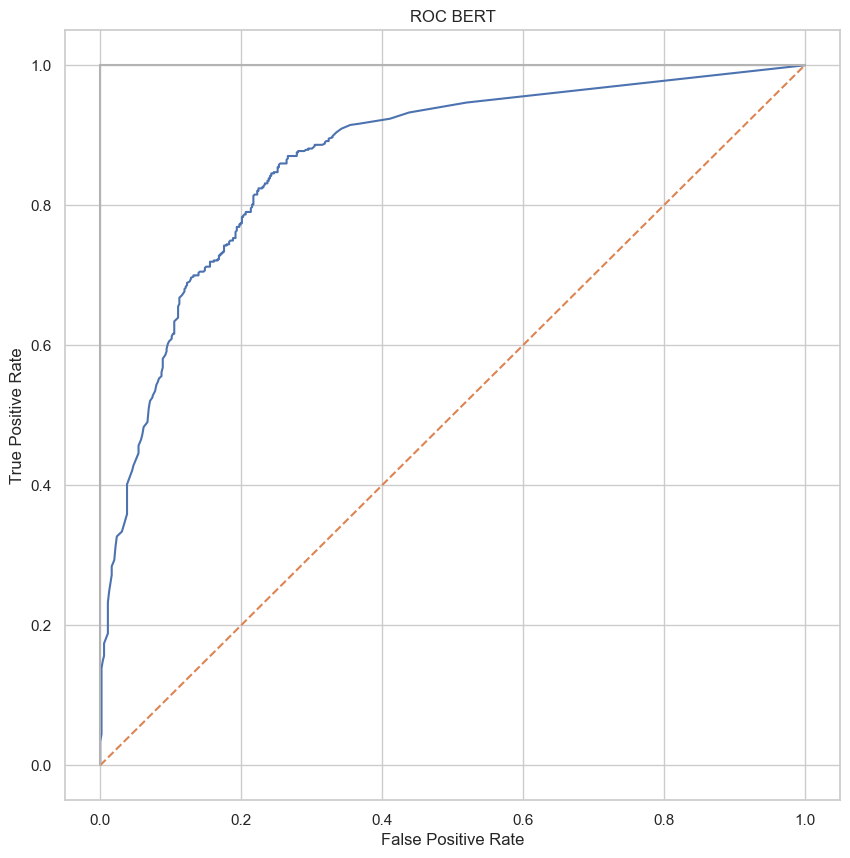

In [39]:
# ROC curve
def Rates(labels,predictions):
    exppred = np.exp(predictions)
    predsoft = exppred/np.sum(exppred)
    predsoft /= np.max(predsoft)
    ratio = np.c_[[(predsoft[:,1]>i) for i in np.linspace(0.01,0.95,1000)]]

    TP = np.sum((labels==ratio)[:,labels==1], 1)
    TN = np.sum((labels==ratio)[:,labels==0], 1)
    FP = np.sum((labels!=ratio)[:,labels==0], 1) 
    FN = np.sum((labels!=ratio)[:,labels==1], 1)

    TPR = TP/(TP+FN) # Recall/sensitivity
    FPR = FP/(FP+TN)

    # AUC score
    aucscore = auc(FPR, TPR)
    return TPR, FPR, aucscore

# balanced dataset
TPR, FPR, auc_b = Rates(labels_b,predictions_b)
# balanced dataset
_,   _, auc_unb = Rates(labels_unb,predictions_unb)
print(auc_b,auc_unb)

# Visualization
plt.subplots(1, figsize=(10,10))
plt.title('ROC BERT')
plt.plot(FPR, TPR)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("50-epochs-roc")

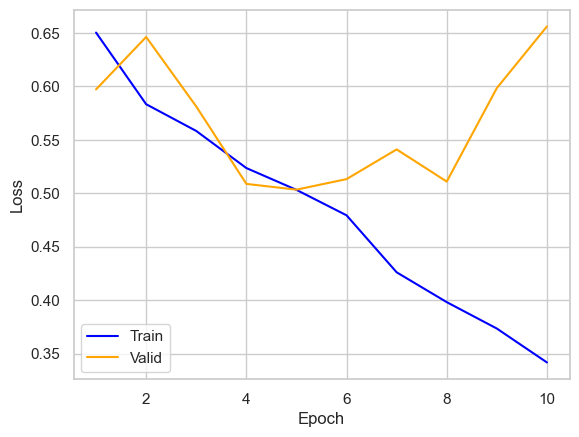

In [41]:
# Training and validation loss

# load data from output file
output = []
for i in ['Output_14988963']:
    with open(f'log/{i}.out') as f:
        output.append(np.array(f.readlines())[1:])
messagedict =  [list(map(ast.literal_eval,run)) for run in output]

mapp = lambda x: [[epoch[x] for epoch in run if x in epoch] for run in messagedict]
eval_loss=mapp('eval_loss');eval_accu=mapp('eval_accuracy');train_loss=mapp('loss') 

# visualize train and validation loss
num_epochs = 10
train_loss_ = np.array(train_loss[0])[np.linspace(0,len(train_loss[0])-1,10).astype(int)]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1,num_epochs+1), y=train_loss_, color='blue', label='Train');
sns.lineplot(x=np.arange(1, num_epochs + 1), y=eval_loss[0], color='orange', label='Valid');
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("test.png")
